In [230]:
#This code heavily references code =used for the following tutorial article:
###https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/


import numpy as np
import pandas as pd
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [231]:
dataset = pd.read_csv('data/500_five_min_intervals_btc.csv')

In [232]:
dataset.head()

,Unnamed: 0,ask,askVolume,average,baseVolume,bid,bidVolume,change,close,datetime,...,low,open,percentage,previousClose,quoteVolume,redd_sent,symbol,timestamp,twi_sent,vwap
0,0,60575.8,NaN,NaN,3181.362949,60575.7,NaN,NaN,60575.8,2021-03-14T23:24:31.515Z,...,59258.8,61174.9,NaN,NaN,1.922725e+08,0.521747,BTC/USD,1.615764e+12,0.192540,60437.15997
1,1,60479.3,NaN,NaN,3174.729925,60470.4,NaN,NaN,60472.4,2021-03-14T23:29:31.235Z,...,59258.8,61174.9,NaN,NaN,1.918609e+08,0.510972,BTC/USD,1.615765e+12,0.155409,60433.77015
2,2,60391.2,NaN,NaN,3183.662191,60391.1,NaN,NaN,60391.2,2021-03-14T23:34:31.722Z,...,59258.8,61174.9,NaN,NaN,1.923922e+08,0.508851,BTC/USD,1.615765e+12,0.169993,60431.11236
3,3,60122.9,NaN,NaN,3187.864044,60117.8,NaN,NaN,60111.7,2021-03-14T23:39:31.413Z,...,59258.8,61174.9,NaN,NaN,1.926364e+08,0.526616,BTC/USD,1.615765e+12,0.158870,60428.04756
4,4,60011.8,NaN,NaN,3205.871977,60008.7,NaN,NaN,60020.1,2021-03-14T23:44:31.704Z,...,59258.8,61174.9,NaN,NaN,1.937058e+08,0.515635,BTC/USD,1.615765e+12,0.133040,60422.18785


In [233]:
dataset['datetime'] = pd.to_datetime(dataset['datetime'],infer_datetime_format = True)

In [234]:
def ticker_shape(dataset):
    dataset = pd.to_datetime(dataset['datetime'],infer_datetime_format = True)
    dataset.set_index(['datetime'],inplace = True)
    values = data.values
    

In [235]:
dataset.head()

,Unnamed: 0,ask,askVolume,average,baseVolume,bid,bidVolume,change,close,datetime,...,low,open,percentage,previousClose,quoteVolume,redd_sent,symbol,timestamp,twi_sent,vwap
0,0,60575.8,NaN,NaN,3181.362949,60575.7,NaN,NaN,60575.8,2021-03-14 23:24:31.515000+00:00,...,59258.8,61174.9,NaN,NaN,1.922725e+08,0.521747,BTC/USD,1.615764e+12,0.192540,60437.15997
1,1,60479.3,NaN,NaN,3174.729925,60470.4,NaN,NaN,60472.4,2021-03-14 23:29:31.235000+00:00,...,59258.8,61174.9,NaN,NaN,1.918609e+08,0.510972,BTC/USD,1.615765e+12,0.155409,60433.77015
2,2,60391.2,NaN,NaN,3183.662191,60391.1,NaN,NaN,60391.2,2021-03-14 23:34:31.722000+00:00,...,59258.8,61174.9,NaN,NaN,1.923922e+08,0.508851,BTC/USD,1.615765e+12,0.169993,60431.11236
3,3,60122.9,NaN,NaN,3187.864044,60117.8,NaN,NaN,60111.7,2021-03-14 23:39:31.413000+00:00,...,59258.8,61174.9,NaN,NaN,1.926364e+08,0.526616,BTC/USD,1.615765e+12,0.158870,60428.04756
4,4,60011.8,NaN,NaN,3205.871977,60008.7,NaN,NaN,60020.1,2021-03-14 23:44:31.704000+00:00,...,59258.8,61174.9,NaN,NaN,1.937058e+08,0.515635,BTC/USD,1.615765e+12,0.133040,60422.18785


In [236]:
dataset.set_index(['datetime'],inplace = True)

In [237]:
data = dataset[['close','baseVolume','redd_sent','twi_sent']].copy()

In [238]:
data.head()

,close,baseVolume,redd_sent,twi_sent
datetime,,,,
2021-03-14 23:24:31.515000+00:00,60575.8,3181.362949,0.521747,0.192540
2021-03-14 23:29:31.235000+00:00,60472.4,3174.729925,0.510972,0.155409
2021-03-14 23:34:31.722000+00:00,60391.2,3183.662191,0.508851,0.169993
2021-03-14 23:39:31.413000+00:00,60111.7,3187.864044,0.526616,0.158870
2021-03-14 23:44:31.704000+00:00,60020.1,3205.871977,0.515635,0.133040


In [239]:
# convert series to supervised learning
###https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [240]:
values = data.values

In [241]:
values = values.astype('float32')

In [242]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [256]:
reframed = series_to_supervised(scaled, 1, 1)

In [257]:
reframed.drop(reframed.columns[[5,6,7]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var1(t)  var1(t+1)  var2(t+1)  \
1   1.000000   0.001353   0.990753   0.459941  0.985638   0.974360   0.001822   
2   0.985638   0.000000   0.970293   0.335671  0.974360   0.935538   0.002679   
3   0.974360   0.001822   0.966266   0.384480  0.935538   0.922816   0.006351   
4   0.935538   0.002679   1.000000   0.347255  0.922816   0.866757   0.010666   
5   0.922816   0.006351   0.979147   0.260804  0.866757   0.836686   0.015361   

   var3(t+1)  var4(t+1)  var1(t+2)  ...  var3(t+2)  var4(t+2)  var1(t+3)  \
1   0.966266   0.384480   0.935538  ...   1.000000   0.347255   0.922816   
2   1.000000   0.347255   0.922816  ...   0.979147   0.260804   0.866757   
3   0.979147   0.260804   0.866757  ...   0.979147   0.251245   0.836686   
4   0.979147   0.251245   0.836686  ...   0.979147   0.176366   0.795766   
5   0.979147   0.176366   0.795766  ...   0.944869   0.308788   0.792489   

   var2(t+3)  var3(t+3)  var4(t+3)  var1(t+4)  var2(t+4)

In [244]:
values = reframed.values

In [245]:
split = int(0.7 * len(values))
train = values[:split,:]
test = values[split:,:]
n_features = 4
n_steps = 1

In [354]:
n_obs = n_steps * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)

(350, 4) 350 (350,)


In [355]:
train_X = train_X.reshape((train_X.shape[0], n_steps, n_features))
test_X = test_X.reshape((test_X.shape[0], n_steps, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(350, 1, 4) (350,) (150, 1, 4) (150,)


In [248]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))
model.add(Dropout(.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(.2))
model.add(Dense(1))
#model.compile(loss='mae', optimizer='adam')
model.compile(optimizer="adam", loss="mean_squared_error")

In [249]:
history = model.fit(train_X, train_y, epochs=100, batch_size=1, validation_data=(test_X, test_y), verbose=1, shuffle=False)

Train on 350 samples, validate on 150 samples
Epoch 1/100
350/350 [==============================] - 11s 32ms/sample - loss: 0.0933 - val_loss: 0.0222
Epoch 2/100
350/350 [==============================] - 4s 10ms/sample - loss: 0.0226 - val_loss: 0.0133
Epoch 3/100
350/350 [==============================] - 3s 10ms/sample - loss: 0.0135 - val_loss: 0.0062
Epoch 4/100
350/350 [==============================] - 3s 9ms/sample - loss: 0.0093 - val_loss: 0.0076
Epoch 5/100
350/350 [==============================] - 3s 9ms/sample - loss: 0.0073 - val_loss: 0.0067
Epoch 6/100
350/350 [==============================] - 3s 9ms/sample - loss: 0.0071 - val_loss: 0.0081
Epoch 7/100
350/350 [==============================] - 3s 9ms/sample - loss: 0.0052 - val_loss: 0.0113
Epoch 8/100
350/350 [==============================] - 3s 9ms/sample - loss: 0.0049 - val_loss: 0.0131
Epoch 9/100
350/350 [==============================] - 3s 9ms/sample - loss: 0.0046 - val_loss: 0.0141
Epoch 10/100
350/350 [=

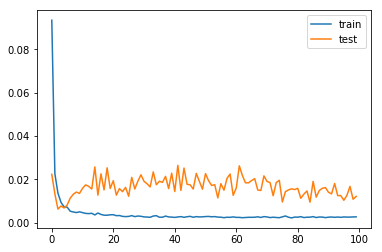

In [258]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [356]:
# make a prediction
yhat = model.predict(test_X)

In [357]:
model.evaluate(test_X, test_y, verbose=1)

150/150 [==============================] - 0s 147us/sample - loss: 0.0121


0.012080754549242557

In [358]:
yhat.shape

(150, 1, 1)

In [359]:
yhat = yhat.reshape(150,1)
feat_cols = -1 * (n_features - 1)

In [360]:
test_X = test_X.reshape((test_X.shape[0], n_steps*n_features))

In [361]:
#inv_yhat = np.concatenate((yhat, test_X[:, -3:]), axis=1)

In [362]:
#inv_yhat = scaler.inverse_transform(inv_yhat)
#inv_yhat = inv_yhat[:,0]

In [363]:
from math import sqrt

In [364]:
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, feat_cols:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [365]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, feat_cols:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 791.326


In [366]:
inv_yhat.shape

(150,)

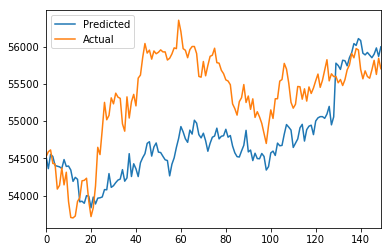

In [367]:
results = {'Predicted':inv_yhat ,'Actual':inv_y}
df_results = pd.DataFrame(results)
df_results.plot()

In [327]:
df_results.head()

,Predicted,Actual
0,54527.476562,54524.300781
1,54362.750000,54589.300781
2,54554.109375,54613.699219
3,54526.132812,54432.898438
4,54405.105469,54423.699219
